### Cab-Driver Agent

# Problem Statement

You are hired as a Sr. Machine Learning Er. at SuperCabs, a leading app-based cab provider in a large Indian metro city. In this highly competitive industry, retention of good cab drivers is a crucial business driver, and you believe that a sound RL-based system for assisting cab drivers can potentially retain and attract new cab drivers. 

 

Cab drivers, like most people, are incentivised by a healthy growth in income. The goal of your project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

## The Need for Choosing the "Right" Requests

Most drivers get a healthy number of ride requests from customers throughout the day. But with the recent hikes in electricity prices (all cabs are electric), many drivers complain that although their revenues are gradually increasing, their profits are almost flat. Thus, it is important that drivers choose the 'right' rides, i.e. choose the rides which are likely to maximise the total profit earned by the driver that day. 

 

For example, say a driver gets three ride requests at 5 PM. The first one is a long-distance ride guaranteeing high fare, but it will take him to a location which is unlikely to get him another ride for the next few hours. The second one ends in a better location, but it requires him to take a slight detour to pick the customer up, adding to fuel costs. Perhaps the best choice is to choose the third one, which although is medium-distance, it will likely get him another ride subsequently and avoid most of the traffic. 

 

There are some basic rules governing the ride-allocation system. If the cab is already in use, then the driver won’t get any requests. Otherwise, he may get multiple request(s). He can either decide to take any one of these requests or can go ‘offline’, i.e., not accept any request at all. 

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time
from itertools import permutations
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from Env import CabDriver

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [3]:
States_track = collections.defaultdict(dict)

In [4]:
def initialise_tracking_states():
    sample_q = [((0, 0, 0), (0,1)), ((0, 0, 0), (0,2))]
    for q_values in sample_q:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = [] 

In [5]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        self.discount_factor = 0.90
        self.learning_rate = 0.001
        self.epsilon_max = 1
        self.epsilon = 1
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00001
        self.batch_size = 32
        self.memory = deque(maxlen=2000)

        self.states_tracked = []
        action = random.choice(list(permutations([i for i in range(5)], 2)) + [(0,0)])
        self.track_state = np.array(env.state_encod_arch2([0,0,0], action)).reshape(1, 46)

        self.model = self.build_model()

    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, actions_index, action_area):
        if np.random.rand() <= self.epsilon:
            index = random.randrange(len(actions_index))
            action_index = actions_index[index]
            action = action_area[action_index]
            return action_index, action
        else:
            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            return np.argmax(q_value[0]), action_area[np.argmax(q_value[0])]
    
    def append_sample(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def train_model(self):
        if len(self.memory) > self.batch_size:
            latest_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            mini_batch = random.sample(self.memory, self.batch_size)

            actions = []
            rewards = []

            for i in range(self.batch_size):
                state, action, reward, next_state = mini_batch[i]
                latest_input[i] = state
                actions.append(action)
                rewards.append(reward)
                update_output[i] = next_state
                target = self.model.predict(latest_input)
                target_qval = self.model.predict(update_output)
            for i in range(self.batch_size):
                target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            self.model.fit(latest_input, target, batch_size=self.batch_size, epochs=1, verbose=0)

    def save(self, name):
        self.model.save_weights(name)

    def store_q_values(self):
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])

In [7]:
Episodes = 1

### DQN block

In [9]:
start_time = time.time()
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

env = CabDriver()
agent = DQNAgent(action_size=len(env.action_space), state_size=len(env.state_encod_arch2(env.state_init, env.action_init)))
for episode in range(Episodes):
    env = CabDriver()
    action_space, state_space, state = env.reset()

    count = 1
    score = 0
    terminal_state = False
    t = 0
    while not terminal_state:
        count += 1
        actions_index, actions = env.requests(state)
        action_index, action = agent.get_action(env.state_encod_arch2(state, random.choice(actions)), actions_index, env.action_space)
        next_state, wait_time, transit_time, ride_time = env.next_state_func(state, action, Time_matrix)
        reward = env.reward_func(state, action, Time_matrix)
        agent.append_sample(env.state_encod_arch2(state, action), action_index, reward, env.state_encod_arch2(next_state, action))
        agent.train_model()
        score += reward
        state = next_state
        t += wait_time + transit_time + ride_time
        if t >= 24 * 20:
            print("State: terminated")
            terminal_state = True

    rewards_per_episode.append(score)
    episodes.append(episode)

    if agent.epsilon > agent.epsilon_min:
        agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(-agent.epsilon_decay*episode)

    print(f"episode {episode}, reward {score}, epsilon {agent.epsilon}")

    if episode % 10 == 0:
        agent.store_q_values()
    if episode % 1000 == 0:
        agent.save(name="model.pkl")
        elapsed_time = time.time() - start_time
        print('Total time ',elapsed_time)

In [27]:
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

Total time taken  7044.020015954971


In [34]:
save_obj(agent.model.weights, 'model')

### Tracking Convergence

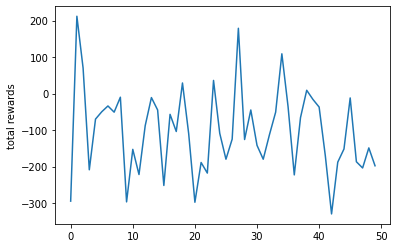

In [28]:
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [29]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

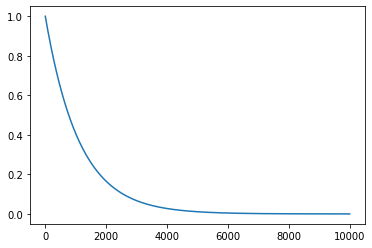

In [30]:
plt.plot(time, epsilon)
plt.show()